In [6]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
# # Primero, bajamos los datos de entrenamiento
# keras.utils.get_file(fname="simpsons_train.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# # Descomprimimos el archivo
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# # Hacemos lo mismo con los datos de test
# keras.utils.get_file(fname="simpsons_test.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
# !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [9]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.85
        if(logs.get('val_accuracy')> accuracy):
            print("\nAlcanzado el {}% de precisión, se cancela el entrenamiento!!".format(accuracy))
            self.model.stop_training = True

In [11]:
callback = myCallback()

In [12]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [13]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [14]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [15]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

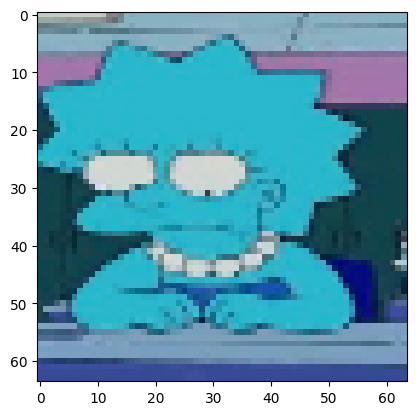

In [16]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro


Prueba batchNormalize


In [17]:
X_scaled = X / 255.0
X_test_scaled = X_test / 255.0
y = y.astype('int')

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [19]:
y_train = to_categorical(y_train, num_classes=18)
y_valid = to_categorical(y_valid, num_classes=18)
y_test = to_categorical(y_test, num_classes=18)

#### Observamos las dimensiones de los conjuntos de datos

In [20]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_valid: {X_valid.shape}')
print(f'Shape y_valid: {y_valid.shape}')

Shape X_train: (15193, 64, 64, 3)
Shape y_train: (15193, 18)
Shape X_valid: (3799, 64, 64, 3)
Shape y_valid: (3799, 18)


#### Podemos desglosar esta información de la siguiente manera
+ 15193 es el número de instancias que tenemos en la variable X_train
+ 64 es el número de píxeles que tiene cada imagen, siendo de 64x64
+ 3 es el número de canales de colores que contiene cada imagen

Para los datos del target, es unidimensional

#### Definimos el early stopping para cortar el entrenamiento cuando el modelo deje de mejorar

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

#### Creamos varias redes neuronales convolucionales que aprendan a diferenciar a los personajes

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    batch_size = 32,
                    callbacks=[early_stopping, callback])

model.evaluate(X_test_scaled, y_test)

Epoch 1/40
475/475 - 28s - loss: 1.6367 - accuracy: 0.5369 - val_loss: 1.7461 - val_accuracy: 0.5259 - 28s/epoch - 58ms/step
Epoch 2/40
475/475 - 27s - loss: 0.7678 - accuracy: 0.7682 - val_loss: 0.9658 - val_accuracy: 0.7131 - 27s/epoch - 57ms/step
Epoch 3/40
475/475 - 28s - loss: 0.4106 - accuracy: 0.8747 - val_loss: 1.1432 - val_accuracy: 0.6862 - 28s/epoch - 58ms/step
Epoch 4/40
475/475 - 28s - loss: 0.2247 - accuracy: 0.9296 - val_loss: 0.7368 - val_accuracy: 0.8084 - 28s/epoch - 58ms/step
Epoch 5/40
475/475 - 27s - loss: 0.1442 - accuracy: 0.9548 - val_loss: 0.8361 - val_accuracy: 0.8026 - 27s/epoch - 57ms/step
Epoch 6/40
475/475 - 27s - loss: 0.1439 - accuracy: 0.9552 - val_loss: 0.9765 - val_accuracy: 0.7757 - 27s/epoch - 57ms/step
Epoch 7/40
475/475 - 27s - loss: 0.1180 - accuracy: 0.9618 - val_loss: 1.1148 - val_accuracy: 0.7878 - 27s/epoch - 57ms/step
Epoch 8/40
475/475 - 27s - loss: 0.1222 - accuracy: 0.9635 - val_loss: 1.4718 - val_accuracy: 0.7210 - 27s/epoch - 57ms/step


[0.2859467566013336, 0.934831440448761]

In [19]:
def pintar_grafica():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

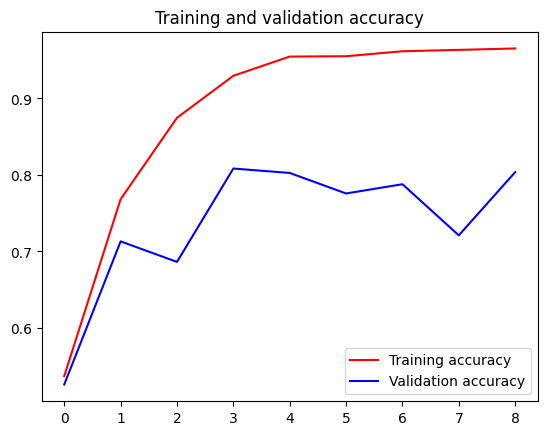

<Figure size 640x480 with 0 Axes>

In [20]:
pintar_grafica()

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    batch_size = 32,
                    callbacks=[early_stopping, callback])

model.evaluate(X_test_scaled, y_test)

Epoch 1/40
475/475 - 27s - loss: 1.6801 - accuracy: 0.5360 - val_loss: 1.6616 - val_accuracy: 0.5028 - 27s/epoch - 58ms/step
Epoch 2/40
475/475 - 27s - loss: 0.8031 - accuracy: 0.7575 - val_loss: 0.9205 - val_accuracy: 0.7386 - 27s/epoch - 56ms/step
Epoch 3/40
475/475 - 27s - loss: 0.4225 - accuracy: 0.8722 - val_loss: 1.2334 - val_accuracy: 0.6954 - 27s/epoch - 56ms/step
Epoch 4/40
475/475 - 27s - loss: 0.2287 - accuracy: 0.9261 - val_loss: 0.9274 - val_accuracy: 0.7776 - 27s/epoch - 56ms/step
Epoch 5/40
475/475 - 27s - loss: 0.1513 - accuracy: 0.9543 - val_loss: 0.9945 - val_accuracy: 0.7710 - 27s/epoch - 57ms/step
Epoch 6/40
475/475 - 27s - loss: 0.1446 - accuracy: 0.9537 - val_loss: 1.2688 - val_accuracy: 0.7386 - 27s/epoch - 56ms/step
Epoch 7/40
475/475 - 27s - loss: 0.1184 - accuracy: 0.9625 - val_loss: 0.8151 - val_accuracy: 0.8347 - 27s/epoch - 57ms/step
Epoch 8/40
475/475 - 26s - loss: 0.0969 - accuracy: 0.9701 - val_loss: 0.8380 - val_accuracy: 0.8357 - 26s/epoch - 56ms/step


[0.5583711862564087, 0.8797752857208252]

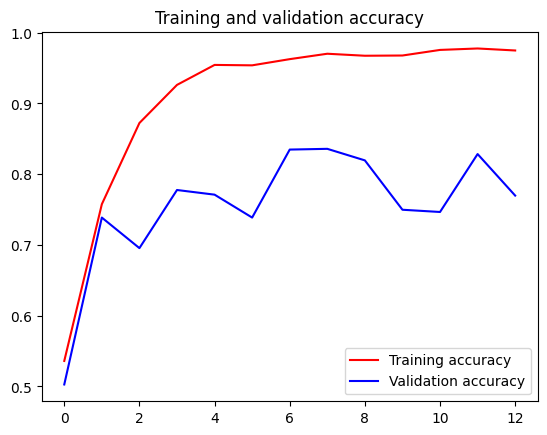

<Figure size 640x480 with 0 Axes>

In [22]:
pintar_grafica()

Prueba

El modelo  tiene un total de 15 capas:

3 capas Conv2D (convolucionales).
3 capas BatchNormalization (normalización por lotes).
3 capas MaxPooling2D (reducción de dimensionalidad).
1 capa Flatten.
1 capa Dropout (regularización).
4 capas Dense (completamente conectadas).

# Modelo CNN definitivo

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

*Ejercicio*  Prueba fully connected. 

In [27]:
#definicion de la arquitectura del modelo secuencial. 
#Comenzamos con una capa convolucional con 32 filtros de tamaño (3, 3) y función de activación ReLU, seguida de una capa de pooling con tamaño de ventana (2, 2). 
#Luego agreamos dos capas convolucionales más con más filtros y capas de pooling correspondientes. 
#A continuación, se aplanan los mapas de características resultantes y se agrega una capa de dropout para evitar el sobreajuste. 
#Luego se agregan dos capas densamente conectadas, con la última capa utilizando una función de activación softmax para la clasificación de las 18 clases
# Por ultimo el resumen del modelo, que incluye información. 

model = Sequential([

    Flatten(input_shape=(64, 64, 3)),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(18, activation='softmax')

])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               6291968   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 18)                2322      
                                                                 
Total params: 6,458,514
Trainable params: 6,458,514
No

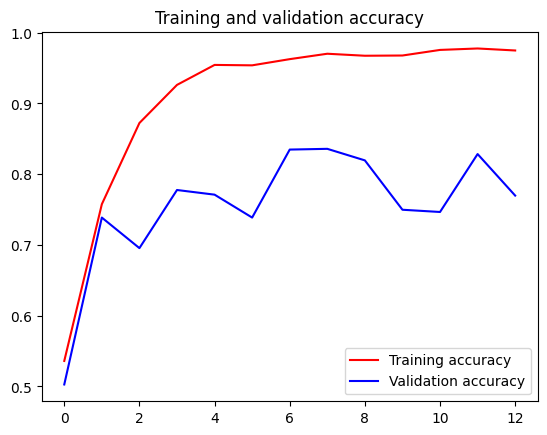

<Figure size 640x480 with 0 Axes>

In [28]:
pintar_grafica()

# Modelo CNN definitivo

In [31]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

# Pruebas CNN BATCH SIZE [32,64,128,256,512]



In [33]:
range(len(acc))

NameError: name 'acc' is not defined

In [32]:

for i in [32,64,128,256,512]:
        print('\n')
        print('-------------------------------------')
        print('-------------------------------------')
        print(f'Prueba con Batch Size: {i}')

        history = model.fit(X_train, y_train,
                epochs=40,
                validation_data=(X_valid, y_valid),
                verbose=2,
                batch_size = 32,
                callbacks=[early_stopping, callback])
        


        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend(loc=0)
        plt.figure()

        plt.show()

        # Evaluar el modelo en el conjunto de datos de prueba
        print(f'\n')
        print(f'Métricas con dataset de validación:')

        valid_loss, valid_acc = model.evaluate(X_valid, y_valid)

        print(f'\n')
        print(f'Métricas con dataset de test:')

        test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

        print(f'\n')



-------------------------------------
-------------------------------------
Prueba con Batch Size: 32
Epoch 1/40


ValueError: in user code:

    File "/home/jesus/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jesus/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jesus/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jesus/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jesus/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jesus/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).
    
    Input 0 of layer "conv2d_16" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)
    
    Call arguments received by layer 'sequential_4' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
      • training=True
      • mask=None


In [ ]:
pintar_grafica()